### Run once everyday

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import LSTM, GRU, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.preprocessing.sequence import TimeseriesGenerator
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

In [2]:
df = pd.read_csv('https://toyokeizai.net/sp/visual/tko/covid19/csv/pcr_positive_daily.csv')
df = df.rename(columns={'日付': 'Date', 'PCR 検査陽性者数(単日)': 'Infected'}) #renaming from Japanese to English
df['Date'] = pd.to_datetime(df['Date'])
print(df.dtypes)
print(df.shape)
df.tail()

Date        datetime64[ns]
Infected           float64
dtype: object
(638, 2)


,Date,Infected
633,2021-10-10,546.0
634,2021-10-11,359.0
635,2021-10-12,609.0
636,2021-10-13,723.0
637,2021-10-14,612.0


In [3]:
def read_from_source():
    df = pd.read_csv('https://toyokeizai.net/sp/visual/tko/covid19/csv/pcr_positive_daily.csv')
    df = df.rename(columns={'日付': 'Date', 'PCR 検査陽性者数(単日)': 'Infected'}) #renaming from Japanese to English
    df['Date'] = pd.to_datetime(df['Date'])
    return df
read_from_source()

,Date,Infected
0,2020-01-16,1.0
1,2020-01-17,0.0
2,2020-01-18,0.0
3,2020-01-19,0.0
4,2020-01-20,0.0
...,...,...
633,2021-10-10,546.0
634,2021-10-11,359.0
635,2021-10-12,609.0
636,2021-10-13,723.0


In [4]:
def pred_covid(model_name, df): #GRU or LSTM
    model = load_model(model_name +'_infected_only_GRU_LSTM_Oct16.h5')
    print(model_name,'loaded')

    #always unchanged
    n_steps_in = 14
    n_steps_out = 4
    sc = MinMaxScaler(feature_range = (0, 1))
    
    x_input = df['Infected'][-n_steps_in:].values # last 14 day
    x_input = sc.fit_transform(x_input.reshape(len(x_input), 1))
    x_input = x_input.reshape((1, n_steps_in, 1))
    
    y_pred = model.predict(x_input)
    y_pred = sc.inverse_transform(y_pred) #revert scaling
    print('Next 4 days prediction:', y_pred)
    
    start_date = str(df['Date'].iloc[-14])[:10]
    end_date = df['Date'].iloc[-15] + pd.Timedelta(18, unit='D')                  
    end_date = str(end_date)[:10]
    print(start_date,'---', end_date)
    time_range = pd.date_range(start=start_date, end=end_date)
    
    pred_list = list(zip(time_range[-4:].strftime('%Y-%m-%d'), y_pred[0,:]))
    return pd.DataFrame (pred_list, columns = ['Date', 'Predict Infected'])

pred_covid('GRU',df)

GRU loaded
Next 4 days prediction: [[537.2245  470.4045  407.93817 352.67615]]
2021-10-01 --- 2021-10-18


,Date,Predict Infected
0,2021-10-15,537.224487
1,2021-10-16,470.404510
2,2021-10-17,407.938171
3,2021-10-18,352.676147


### Load LSTM

In [5]:
model_lstm = load_model('LSTM_infected_only_GRU_LSTM_Oct16.h5')
model_lstm

In [6]:
n_steps_in = 14
n_steps_out = 4

In [7]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))

In [8]:
x_input = df['Infected'][-n_steps_in:].values # last 14 day
x_input = sc.fit_transform(x_input.reshape(len(x_input), 1))
x_input = x_input.reshape((1, n_steps_in, 1))
print(x_input.shape)

(1, 14, 1)


In [9]:
y_pred = model_lstm.predict(x_input)
y_pred = sc.inverse_transform(y_pred) #revert scaling
print(y_pred)

[[664.68115 617.5858  570.1588  481.71854]]


In [10]:
x_input_raw = df['Infected'][-n_steps_in:].values
print(x_input_raw.reshape(n_steps_in))

[1443. 1232.  959.  576.  971. 1117.  969.  824.  770.  546.  359.  609.
  723.  612.]


### Range: 18 days

In [11]:
start_date = str(df['Date'].iloc[-14])[:10]

end_date = df['Date'].iloc[-15] + pd.Timedelta(18, unit='D')                  
end_date = str(end_date)[:10]

print(start_date,'---', end_date)

2021-10-01 --- 2021-10-18


In [12]:
time_range = pd.date_range(start=start_date, end=end_date)
print(time_range.shape)

(18,)


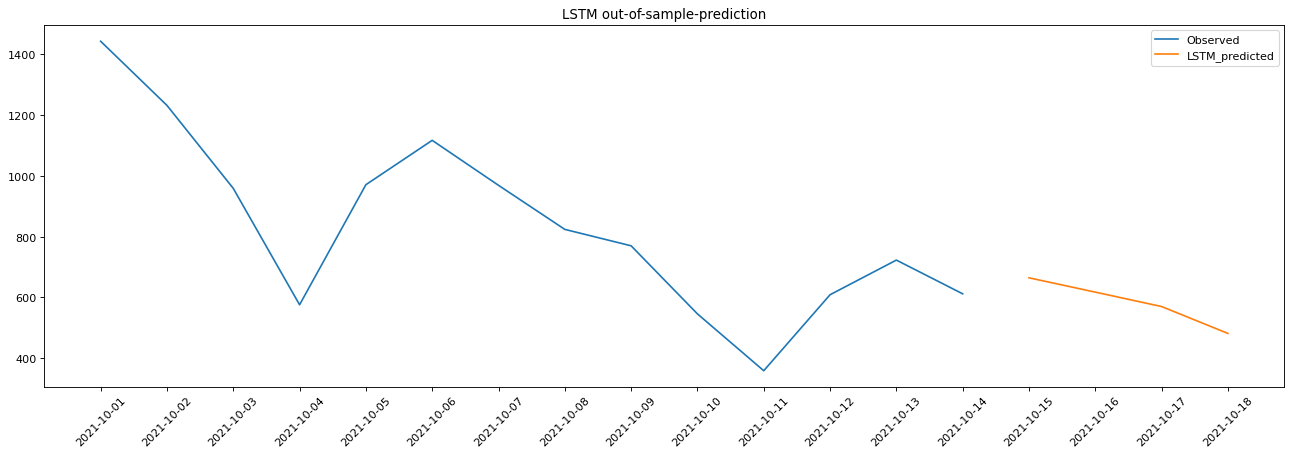

In [13]:
from matplotlib.pyplot import figure
figure(figsize=(20, 6), dpi=80)

plt.plot(time_range[:14],x_input_raw.reshape(n_steps_in), label='Observed')
plt.plot(time_range[14:], y_pred[0,:], label='LSTM_predicted')
plt.title('LSTM out-of-sample-prediction')
plt.xticks(time_range,rotation=45)
plt.legend()
plt.show()

### Load GRU

In [14]:
model_GRU = load_model('GRU_infected_only_GRU_LSTM_Oct16.h5')
model_GRU

In [15]:
n_steps_in = 14
n_steps_out = 4

In [16]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))

In [17]:
x_input = df['Infected'][-n_steps_in:].values # last 14 day
x_input = sc.fit_transform(x_input.reshape(len(x_input), 1))
x_input = x_input.reshape((1, n_steps_in, 1))
print(x_input.shape)

(1, 14, 1)


In [18]:
y_pred_GRU = model_GRU.predict(x_input)
y_pred_GRU = sc.inverse_transform(y_pred_GRU) #revert scaling
print(y_pred_GRU)

[[537.2245  470.4045  407.93817 352.67615]]


In [19]:
x_input_raw = df['Infected'][-n_steps_in:].values
print(x_input_raw.reshape(n_steps_in))

[1443. 1232.  959.  576.  971. 1117.  969.  824.  770.  546.  359.  609.
  723.  612.]


### Range: 18 days

In [20]:
start_date = str(df['Date'].iloc[-14])[:10]

end_date = df['Date'].iloc[-15] + pd.Timedelta(18, unit='D')                  
end_date = str(end_date)[:10]

print(start_date,'---', end_date)

2021-10-01 --- 2021-10-18


In [21]:
time_range = pd.date_range(start=start_date, end=end_date)
print(time_range.shape)

(18,)


In [22]:
y_pred_GRU[0,:]

array([537.2245 , 470.4045 , 407.93817, 352.67615], dtype=float32)

In [23]:
pred_list = list(zip(time_range[-4:].strftime('%Y-%m-%d'), y_pred_GRU[0,:]))
pred_list

[('2021-10-15', 537.2245),
 ('2021-10-16', 470.4045),
 ('2021-10-17', 407.93817),
 ('2021-10-18', 352.67615)]

In [24]:
pd.DataFrame (pred_list, columns = ['Date', 'Predict Infected'])

,Date,Predict Infected
0,2021-10-15,537.224487
1,2021-10-16,470.404510
2,2021-10-17,407.938171
3,2021-10-18,352.676147


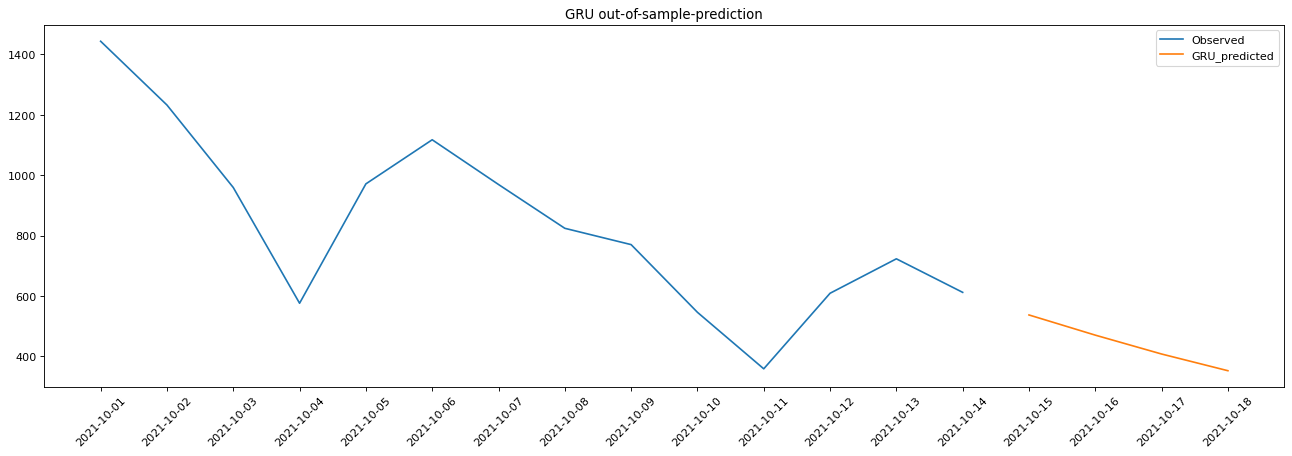

In [25]:
from matplotlib.pyplot import figure
figure(figsize=(20, 6), dpi=80)

plt.plot(time_range[:14],x_input_raw.reshape(n_steps_in), label='Observed')
plt.plot(time_range[14:], y_pred_GRU[0,:], label='GRU_predicted')
plt.title('GRU out-of-sample-prediction')
plt.xticks(time_range,rotation=45)
plt.legend()
plt.show()